In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

%matplotlib inline

In [53]:
df_scripts = pd.read_csv('data/scripts3.csv')
df_scripts = df_scripts.drop("Unnamed: 3", axis=1)
df_tags = pd.read_csv('data/tags.csv')
df_tags = df_tags.drop("Unnamed: 2", axis=1)
df_scripts.head(n=2)

,Id,Body,Film
0,0,"['ustache, the hopeful look of youth in his ey...",familymanthe
1,1,"['DAYA restaurant supply truck is curbside, ne...",broadcastnews


In [33]:
grouped_tags = df_tags.groupby("Tag", sort='count').size().reset_index(name='count')
print(grouped_tags)

         Tag  count
0     Action    114
1  Adventure    108
2     Comedy    237
3      Crime     27
4      Drama    127
5     Horror     81
6    Mystery     99
7    Romance    192
8   Thriller     77


In [55]:
num_classes = 9
grouped_tags = df_tags.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(num_classes, columns="count")
df_tags.Tag = df_tags.Tag.apply(lambda tag : tag if tag in most_common_tags.Tag.values else None)
df_tags = df_tags.dropna()

In [5]:
counts = df_tags.Tag.value_counts()
firstlast = counts[:5].append(counts[-5:])
# firstlast.reset_index(name="count")


In [57]:
def tags_for_question(question_id):
    return df_tags[df_tags['Id'] == question_id].Tag.values

def add_tags_column(row):
    row['Tags'] = tags_for_question(row['Id'])
    return row

df_scripts = df_scripts.apply(add_tags_column, axis=1)
df_scripts[['Id', 'Body', 'Tags']].head()

,Id,Body,Tags
0,0,"['ustache, the hopeful look of youth in his ey...","[Romance, Comedy]"
1,1,"['DAYA restaurant supply truck is curbside, ne...","[Romance, Comedy, Drama]"
2,2,['LGRIM\'S STALL - MORNINGSunlit illuminates t...,"[Romance, Drama]"
3,3,['GICIAN is entertaining guests. Playing cards...,"[Romance, Comedy]"
4,4,['TER SCREENThe game is in progress. As a sick...,"[Romance, Comedy, Adventure]"


In [37]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_scripts.Tags)
Y = multilabel_binarizer.transform(df_scripts.Tags)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_scripts.Body)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts).toarray()

In [38]:
featureslist = []
for i,film in enumerate(df_scripts.Film):
    features = np.loadtxt('data/extracted_features2/' + film + '.txt')
    featureslist.append(features)
feat = np.array(featureslist)

In [10]:
print(feat.shape, X_tfidf.shape, type(feat), type(X_tfidf))

(1062, 175) (1062, 344750) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [39]:
X_tfidf = np.concatenate((feat, X_tfidf), axis = 1)

In [12]:
X_tfidf.shape

(1062, 344925)

In [40]:
ros = RandomOverSampler(random_state=42)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)

In [41]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, Y_tfidf_resampled, test_size=0.2)

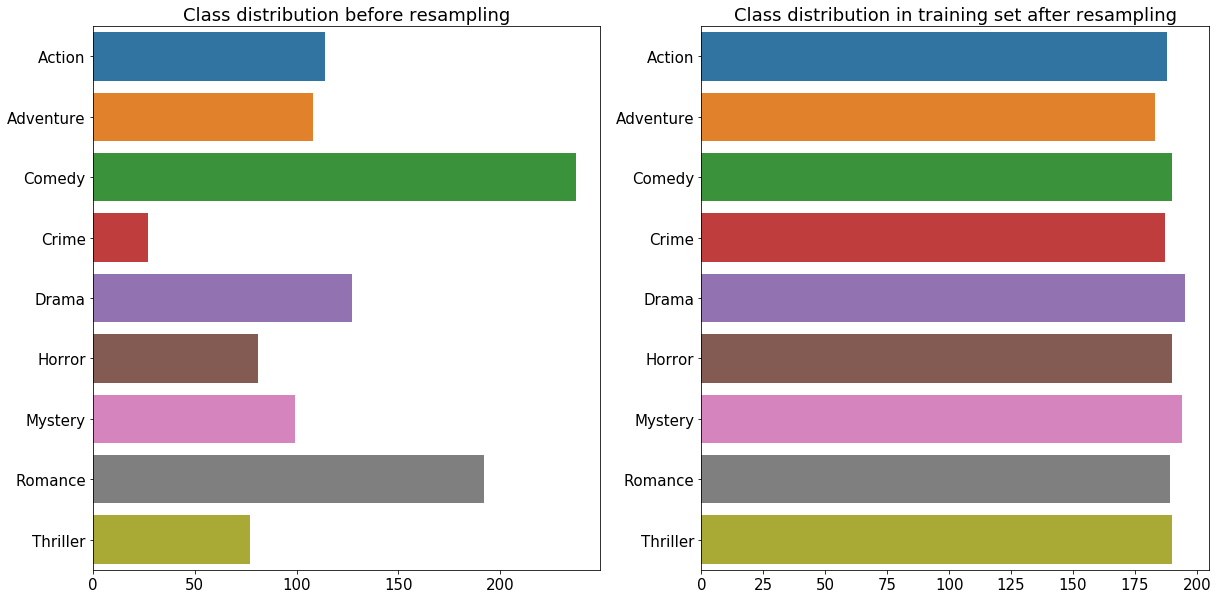

In [42]:
font = {'family' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
fig = plt.figure(figsize=(20,10))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=Y.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_test)
g2 = sns.barplot(x=y_train_tfidf.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_train)
g1.set_title("Class distribution before resampling")
g2.set_title("Class distribution in training set after resampling")
fig.savefig('g1')

In [15]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Classifier: ", clf.__class__.__name__)
    print("Hamming Loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming Score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")

In [43]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, max_iter=15, tol=None, verbose=1)
classes = ["Action", "Adventure", "Comedy", "Crime", "Drama", "Horror", "Mystery", "Romance", "Thriller"]
for classifier in [sgd]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    cr = classification_report(y_test_tfidf, y_pred, target_names=classes)
#     cm = confusion_matrix(y_test_tfidf, y_pred)
    print_score(y_pred, classifier)

-- Epoch 1
Norm: 61.18, NNZs: 133510, Bias: -1.816181, T: 1706, Avg. loss: 1.006760
Total training time: 0.94 seconds.
-- Epoch 2
Norm: 57.72, NNZs: 159945, Bias: -2.011151, T: 3412, Avg. loss: 0.258839
Total training time: 1.84 seconds.
-- Epoch 3
Norm: 50.71, NNZs: 175310, Bias: -2.056013, T: 5118, Avg. loss: 0.120998
Total training time: 2.71 seconds.
-- Epoch 4
Norm: 46.31, NNZs: 184126, Bias: -2.059892, T: 6824, Avg. loss: 0.062610
Total training time: 3.56 seconds.
-- Epoch 5
Norm: 43.78, NNZs: 192724, Bias: -3.115775, T: 8530, Avg. loss: 0.052540
Total training time: 4.47 seconds.
-- Epoch 6
Norm: 42.55, NNZs: 203508, Bias: -2.055130, T: 10236, Avg. loss: 0.050693
Total training time: 5.34 seconds.
-- Epoch 7
Norm: 40.88, NNZs: 209607, Bias: -2.043418, T: 11942, Avg. loss: 0.034439
Total training time: 6.30 seconds.
-- Epoch 8
Norm: 39.44, NNZs: 218710, Bias: -1.326668, T: 13648, Avg. loss: 0.029383
Total training time: 7.21 seconds.
-- Epoch 9
Norm: 37.12, NNZs: 221141, Bias: -

Norm: 38.90, NNZs: 253879, Bias: -1.786344, T: 17060, Avg. loss: 0.034024
Total training time: 8.98 seconds.
-- Epoch 11
Norm: 37.96, NNZs: 256551, Bias: -1.259899, T: 18766, Avg. loss: 0.028980
Total training time: 9.88 seconds.
-- Epoch 12
Norm: 36.64, NNZs: 259073, Bias: -1.734478, T: 20472, Avg. loss: 0.025968
Total training time: 10.83 seconds.
-- Epoch 13
Norm: 35.50, NNZs: 259801, Bias: -1.275323, T: 22178, Avg. loss: 0.020736
Total training time: 11.76 seconds.
-- Epoch 14
Norm: 34.59, NNZs: 261241, Bias: -1.682169, T: 23884, Avg. loss: 0.021688
Total training time: 12.59 seconds.
-- Epoch 15
Norm: 34.04, NNZs: 264136, Bias: -1.281670, T: 25590, Avg. loss: 0.018609
Total training time: 13.46 seconds.
-- Epoch 1
Norm: 69.56, NNZs: 124646, Bias: -5.882088, T: 1706, Avg. loss: 0.847109
Total training time: 1.01 seconds.
-- Epoch 2
Norm: 54.38, NNZs: 136535, Bias: -6.112380, T: 3412, Avg. loss: 0.138516
Total training time: 1.94 seconds.
-- Epoch 3
Norm: 49.81, NNZs: 153481, Bias: 

/Users/cristianlomeli/Documents/CS224U/CS224U-Final/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [72]:
# Credit goes to Karina H from Kagel for much of the code:
# https://www.kaggle.com/roccoli/multi-label-classification-with-sklearn